# Flight Delays Predictions ML Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import calendar
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

from collections import Counter
from imblearn.combine import SMOTEENN 

import pickle

## Loading Data

In [2]:
file = './data/df_flight_weather_8.csv'
df_original = pd.read_csv(file)
df = pd.read_csv(file)

In [3]:
min_delayed = 0
conditions = [
    df['ARRIVAL_DELAY_MIN'] > min_delayed,
    df['ARRIVAL_DELAY_MIN'] <= min_delayed,
    df['ARRIVAL_DELAY_MIN'].isna()
]

results = ['DELAYED', 'ON_TIME', 'OTHER'] 

df['STATUS'] = pd.Series(np.select(conditions, results, 'OTHER'))

df['CATEGORY'] = pd.Series(np.select([df['STATUS']=='DELAYED', df['STATUS']=='ON_TIME'], [1, 0], -1))

## Exploring Data

In [5]:
df.STATUS.value_counts()

ON_TIME    2453956
DELAYED    1078698
Name: STATUS, dtype: int64

In [6]:
total = df['STATUS'].count()

on_time =  df[(df['STATUS']=='ON_TIME')]['STATUS'].count()
delay =  df[(df['STATUS']=='DELAYED')]['STATUS'].count()

percentage_delay = delay / total
percentage_ontime = on_time / total
print("Proportions: {}, {}".format(percentage_delay, percentage_ontime))

Proportions: 0.3053505947652954, 0.6946494052347045


<AxesSubplot:xlabel='STATUS', ylabel='Count'>

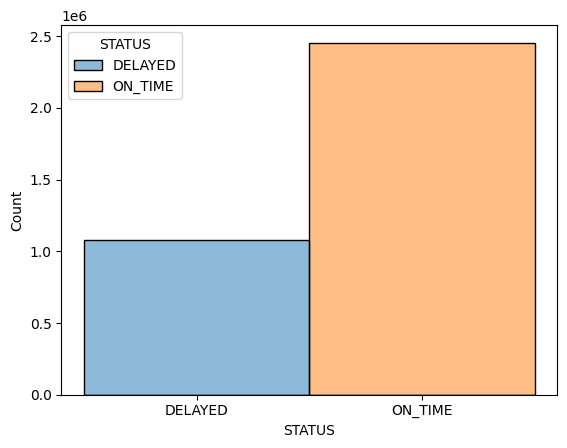

In [7]:
sns.histplot(data=df, x="STATUS", hue="STATUS")

In [8]:
# Encode the object as an enumerated type or categorical variable.

code_airlines, uniques_airlines = pd.factorize(df['AIRLINE'])
df['AIRLINE_CODE'] = code_airlines

code_airport, unique_airport = pd.factorize(df['ORIGIN_AIRPORT'])
df['ORIGIN_AIRPORT_CODE'] = code_airport

code_dairport, unique_dairport = pd.factorize(df['DESTINATION_AIRPORT'])
df['DESTINATION_AIRPORT_CODE'] = code_dairport


## Class Balancing

In [9]:
X = df[['SCHEDULED_DEPATURE_HR','SCHEDULED_ARRIVAL_HR', 'AIRLINE_CODE', 'PRESSURE', 
        'PRESSURE_DEST', 'ORIGIN_AIRPORT_CODE', 'RH_DEST', 'RH', 'DESTINATION_AIRPORT_CODE',
        'DEWPT_DEST', 'DEWPT']]

y = df['CATEGORY']    

In [10]:
# SMOTEENN, it's a method that combines over-sampling and under-sampling. 
# It's a class to perform over-sampling using SMOTE and cleaning using ENN.

sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)

X, y = X_res, y_res 
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({1: 1460538, 0: 878900})


## Creating Dataset to Train ML Model

In [11]:
resampledDf = pd.concat([X, y], axis=1)
resampledDf.to_csv('./data/resampledDF.csv')

In [16]:
# Splitting Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101)

## Training & Fitting Model

In [17]:
# Creating the Random Forest model
rfc = RandomForestClassifier(bootstrap=True, 
                             class_weight=None, 
                             criterion='gini', 
                             n_estimators=100, 
                             n_jobs=None)

# Fitting the model
rfc.fit(X_train, y_train)

# Making predictions
predictionsrfc = rfc.predict(X_test)

## Model Performance Metrics

In [20]:
# Calculating Accuracy Score
accu_score = round(metrics.accuracy_score(y_test, predictionsrfc), 4)
print('Accuracy Score:{} \n'.format(accu_score))

# Classification Report
print(classification_report(y_test, predictionsrfc, target_names=["ON TIME", "DELAYED"]))

Accuracy Score:0.8658 

              precision    recall  f1-score   support

     ON TIME       0.87      0.76      0.81    263539
     DELAYED       0.86      0.93      0.90    438293

    accuracy                           0.87    701832
   macro avg       0.87      0.84      0.85    701832
weighted avg       0.87      0.87      0.86    701832



## Creating Pickle File (used by Streamlit code)

In [19]:
# Pickle Module: Transform a complex object into a byte stream
# Creating a pickle file to be called by streamlit code

rf_pickle = open('flight_delay.pkl', 'wb')
pickle.dump(rfc, rf_pickle)
rf_pickle.close()